<a href="https://colab.research.google.com/github/MattHodgman/ProteoHist/blob/main/cohort_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore cohort statistics
- confounders
- batch effects
- etc.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn3, venn3_circles

In [48]:
# Load data
df_histology = pd.read_csv('/content/drive/MyDrive/BIOINF_590/Data/Metadata/cohort.csv') # load histology metadata
df_proteomic = pd.read_excel('/content/drive/MyDrive/BIOINF_590/Data/Metadata/mmc1.xlsx') # load df_proteomic metadata
df_normal_proteomics = pd.read_csv('/content/drive/MyDrive/BIOINF_590/Data/ExpressionData/ucec_proteome_normal.txt', delimiter='\t')
df_tumor_proteomics = pd.read_csv('/content/drive/MyDrive/BIOINF_590/Data/ExpressionData/ucec_proteome_tumor.txt', delimiter='\t')

df_hist_prot = pd.merge(df_histology, df_proteomic, 
              left_on='Case_ID', right_on='Proteomics_Participant_ID', 
              suffixes=['_histology','_proteomics'])

# format and combine df
df_normal_proteomics['Group'] = 'normal'
df_tumor_proteomics['Group'] = 'tumor'
df_target_proteins = pd.concat([df_normal_proteomics, df_tumor_proteomics])[['sample','Group']]
df_new = pd.merge(df_hist_prot, df_target_proteins, left_on='Case_ID', right_on='sample')
df_new.loc[df_new['Tumor_Percent_Tumor_Nuclei'] < 90, 'Group'] = 'both'
df = df_new[df_new['Case_excluded'] == 'No']

## Continuous Variables
I believe the column 'Age_at_Diagnosis' has been shifted for deidentification.

In [51]:
continuous_cols = ['Weight','Tumor_Percent_Tumor_Nuclei','Tumor_Percent_Total_Cellularity',
                   'Tumor_Percent_Necrosis','BMI','Age', 'Group']

In [52]:
def get_stats(df0, stat):
  
  df0 = df0[continuous_cols]

  if stat == 'mean':
    df0 = df0.groupby('Group').mean().T
  elif stat == 'std':
    df0 = df0.groupby('Group').std().T

  df0.columns.name = None
  df0.index.name = None

  return df0

In [53]:
get_stats(df, 'mean')

,both,normal,tumor
Weight,95.238312,91.478000,95.334857
Tumor_Percent_Tumor_Nuclei,75.389908,91.071429,91.506667
Tumor_Percent_Total_Cellularity,88.110092,86.535714,90.746667
Tumor_Percent_Necrosis,2.876147,3.000000,2.526667
BMI,35.463141,36.198788,34.436932
Age,62.397436,66.818182,63.095618


In [54]:
get_stats(df, 'std')

,both,normal,tumor
Weight,30.005821,20.142433,28.046603
Tumor_Percent_Tumor_Nuclei,15.132572,2.070197,2.370814
Tumor_Percent_Total_Cellularity,12.475849,9.728990,8.081952
Tumor_Percent_Necrosis,6.522438,4.431294,3.590997
BMI,11.187146,8.141054,10.531302
Age,9.869915,8.335114,10.053398


In [55]:
df_cont_m = get_stats(df, 'mean')
df_cont_std = get_stats(df, 'std')

df_cont_m['both'] = df_cont_m['both'].round(1).astype(str) + ' (±' + df_cont_std['both'].round(1).astype(str) + ')'
df_cont_m['normal'] = df_cont_m['normal'].round(1).astype(str) + ' (±' + df_cont_std['normal'].round(1).astype(str) + ')'
df_cont_m['tumor'] = df_cont_m['tumor'].round(1).astype(str) + ' (±' + df_cont_std['tumor'].round(1).astype(str) + ')'

In [56]:
df_cont_m.to_csv('/content/drive/MyDrive/BIOINF_590/Data/group_continuous_variables_mean_std.csv')

## Categorical Variables

In [57]:
categorical_cols = ['Specimen_Type','Tumor_Site_histology','Tumor_Histological_Type',
                    'Tumor_Segment_Acceptable','Progression_or_Recurrence',
                    'Ethnicity_histology','Race_histology',
                    'Vital_Status','Proteomics_TMT_batch','Country',
                    'Histologic_Grade_FIGO','Myometrial_invasion_Specify','Histologic_type',
                    'tumor_Stage-Pathological','Diabetes',
                    'Tumor_Site_proteomics','Tumor_Site_Other']

In [58]:
def myfunc(df0):
  dfs = []

  for col in categorical_cols:

    df = pd.DataFrame(df0.groupby('Group')[col].value_counts())
    df = df.rename(columns={col : 'value'})
    df['Group'] = df.index.get_level_values(0)
    df = df.droplevel(0)
    df = df.pivot(columns='Group', values='value')
    df = pd.concat({col: df}, names=['Feature'])
    dfs.append(df)

  # combine features dfs
  df = pd.DataFrame()
  for feature_df in dfs:
    df = pd.concat([df,feature_df])

  df = df.fillna(0)

  # add percentage columns
  n_normal = df0['Group'].value_counts()['normal']
  n_tumor = df0['Group'].value_counts()['tumor']
  n_both = df0['Group'].value_counts()['both']
  
  df['normal'] = df['normal'].astype(int).astype(str) + ' (' + ((df['normal'] / n_normal) * 100).round(1).astype(str) + '%)'
  df['tumor'] = df['tumor'].astype(int).astype(str) + ' (' + ((df['tumor'] / n_tumor) * 100).round(1).astype(str) + '%)'
  df['both'] = df['both'].astype(int).astype(str) + ' (' + ((df['both'] / n_both) * 100).round(1).astype(str) + '%)'

  # df['normal_freq'] = ((df['normal'] / n_normal)).round(2)
  # df['tumor_freq'] = ((df['tumor'] / n_tumor)).round(2)
  # df['both_freq'] = ((df['both'] / n_both)).round(2)

  df.columns.name = None
  df.index.names = (None,None)

  return df

In [59]:
df_categorical_variables = myfunc(df)

In [60]:
df_categorical_variables

both  \
Specimen_Type        normal_tissue                                  0 (0.0%)   
                     tumor_tissue                               218 (100.0%)   
Tumor_Site_histology Anterior and Posterior                         2 (0.9%)   
                     Anterior and Posterior endometrium             7 (3.2%)   
                     Anterior and posterior endometrium             5 (2.3%)   
...                                                                      ...   
Tumor_Site_Other     anterior and posterior                         0 (0.0%)   
                     anterior and posterior endometrial cavity      2 (0.9%)   
                     both anterior and posterior                    4 (1.8%)   
                     entire uterine cavity                          0 (0.0%)   
                     left cornu                                     2 (0.9%)   

                                                                    normal  \
Specimen_Type        normal_tissue                              76 (57.6%)   
                     tumor_tissue                               56 (42.4%)   
Tumor_Site_histology Anterior and Posterior                       0 (0.0%)   
                     Anterior and Posterior endometrium          10 (7.6%)   
                     Anterior and posterior endometrium           0 (0.0%)   
...                                                                    ...   
Tumor_Site_Other     anterior and posterior                       0 (0.0%)   
                     anterior and posterior endometrial cavity    4 (3.0%)   
                     both anterior and posterior                  3 (2.3%)   
                     entire uterine cavity                        0 (0.0%)   
                     left cornu                                   1 (0.8%)   

                                                                      tumor  
Specimen_Type        normal_tissue                              167 (52.7%)  
                     tumor_tissue                               150 (47.3%)  
Tumor_Site_histology Anterior and Posterior                        7 (2.2%)  
                     Anterior and Posterior endometrium           15 (4.7%)  
                     Anterior and posterior endometrium            5 (1.6%)  
...                                                                     ...  
Tumor_Site_Other     anterior and posterior                        3 (0.9%)  
                     anterior and posterior endometrial cavity     4 (1.3%)  
                     both anterior and posterior                   3 (0.9%)  
                     entire uterine cavity                         2 (0.6%)  
                     left cornu                                    1 (0.3%)  

[99 rows x 3 columns]

In [61]:
df_categorical_variables.to_csv('/content/drive/MyDrive/BIOINF_590/Data/group_categorical_variables_formatted.csv')

## Other

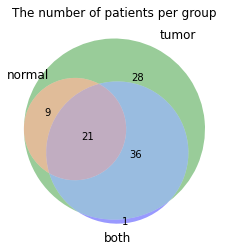

In [62]:
# Stratify patients by what groups their samples are in

normal_patients = set(df[df['Group'] == 'normal']['Case_ID'].unique())
tumor_patients = set(df[df['Group'] == 'tumor']['Case_ID'].unique())
both_patients = set(df[df['Group'] == 'both']['Case_ID'].unique())

venn3([normal_patients, tumor_patients, both_patients], ('normal', 'tumor', 'both'))

plt.title('The number of patients per group')
plt.show()